In [6]:
# --------------------------------------------------------------
# File: CleaningAgentsUpgraded.ipynb
# Authors: Juan Ferro and Aditi Deepak
# Created: November 2025
# Description: Jupyter Notebook for simulating multiple cleaning agents
#              moving through a grid environment, cleaning dirty cells,
#              and reporting total movements and cleaning performance.
# --------------------------------------------------------------

"""
CleaningAgentsUpgraded.ipynb

This notebook defines and runs a cleaning agent simulation.
Agents move randomly across a grid, cleaning dirty cells, tracking
their number of movements, and calculating:
- Percentage of clean cells after the simulation.
- Total number of movements made by all agents.
- Time required for the environment to become fully clean.
"""


'\nCleaningAgentsUpgraded.ipynb\n\nThis notebook defines and runs a cleaning agent simulation.\nAgents move randomly across a grid, cleaning dirty cells, tracking\ntheir number of movements, and calculating:\n- Percentage of clean cells after the simulation.\n- Total number of movements made by all agents.\n- Time required for the environment to become fully clean.\n'

## Installing dependencies

In [1]:
pip install -U mesa


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install altair


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install solara

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached websockets-15.0.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 25.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 23.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.5 MB/s  0:00:00
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
Using cached sniffio-1.3.1-py3-none-any.whl (10 kB)
Using cached h11-0.16.0-py3-none-any.whl (37 kB)
Using cached websockets-15.0.1-cp312-cp312-macosx_11_0_arm64.whl (173

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import mesa

import mesa;
print(mesa.__version__)



3.3.1


## Initializing Model

In [8]:
# === Limpieza con SolaraViz (Mesa >= 3.1) ===
import math
from typing import Tuple, Set

from mesa import Model
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid

# -----------------------------
# Utilidades
# -----------------------------
def get_cell_by_coords(space, x, y):
    sel = space.all_cells.select(lambda c: c.coordinate == (x, y), at_most=1)
    return sel.cells[0] if sel.cells else None


# -----------------------------
# Agentes
# -----------------------------
class DirtCell(CellAgent):
    """Agente estático por celda; su color depende de `dirty`."""
    def __init__(self, model: Model, cell, dirty: bool):
        super().__init__(model)
        self.cell = cell
        self.dirty = dirty

    def set_clean(self):
        self.dirty = False

    def step(self):
        pass


class CleanAgent(CellAgent):
    def __init__(self, model: Model, cell):
        super().__init__(model)
        self.cell = cell
        self.moves = 0

    def _rand_moore_neighbor_cell(self):
        neighbors = list(self.cell.neighborhood.cells)
        return self.model.random.choice(neighbors) if neighbors else None

    def _clean_here(self):
        # En algunos builds de Mesa 3.x, cell.agents es list (sin .select)
        coord = self.cell.coordinate
        dirt_list = [a for a in self.cell.agents if isinstance(a, DirtCell) and getattr(a, "dirty", False)]
        for d in dirt_list:
            d.set_clean()
        if dirt_list:
            self.model.dirty_cells.discard(coord)

    def step(self):
        # Limpia donde está
        self._clean_here()
        # Muévete
        new_cell = self._rand_moore_neighbor_cell()
        if new_cell:
            self.cell = new_cell
            self.moves += 1
            self.model.total_moves += 1
            # Limpia al llegar
            self._clean_here()


# -----------------------------
# Modelo
# -----------------------------
class CleaningModel(Model):
    def __init__(
        self,
        width: int = 20,
        height: int = 20,
        num_agents: int = 5,
        dirty_pct: float = 0.35,
        max_steps: int = 10_000,
        seed: int | None = 42,
        torus: bool = False,
    ):
        super().__init__(seed=seed)
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.max_steps = max_steps
        self.step_count = 0
        self.total_moves = 0
        self.time_to_all_clean: int | None = None

        self.grid = OrthogonalMooreGrid(
            (self.width, self.height),
            capacity=math.inf,
            torus=torus,
            random=self.random,
        )

        # Celdas sucias iniciales
        all_coords = [(x, y) for x in range(self.width) for y in range(self.height)]
        self.random.shuffle(all_coords)
        k = int(round(max(0.0, min(1.0, dirty_pct)) * len(all_coords)))
        self.dirty_cells: Set[Tuple[int, int]] = set(all_coords[:k])

        # Crear DirtCell para TODAS las celdas (pinta tablero)
        for x in range(self.width):
            for y in range(self.height):
                c = get_cell_by_coords(self.grid, x, y)
                if c:
                    DirtCell(self, c, dirty=((x, y) in self.dirty_cells))

        # Crear agentes limpiadores en (0,0)
        start_cell = get_cell_by_coords(self.grid, 0, 0)
        if start_cell is None:
            raise RuntimeError("No pude localizar la celda (0,0).")
        CleanAgent.create_agents(self, self.num_agents, [start_cell] * self.num_agents)

    def step(self):
        if self.step_count >= self.max_steps:
            return
        self.agents.shuffle_do("step")
        self.step_count += 1
        if not self.dirty_cells and self.time_to_all_clean is None:
            self.time_to_all_clean = self.step_count


# -----------------------------
# Portrayal (colores)
# -----------------------------
def agent_portrayal(agent):
    if isinstance(agent, DirtCell):
        color = "#6b6b6b" if agent.dirty else "#FFFFFF"  # gris si sucia, verde si limpia
        return AgentPortrayalStyle(
            size=100, color=color, marker="s", alpha=0.5
        )
    if isinstance(agent, CleanAgent):
        return AgentPortrayalStyle(
            size=55, color="tab:orange", marker="o", alpha=1
        )
    return AgentPortrayalStyle(size=50, color="tab:blue")


# -----------------------------
# Controles (sliders) en la UI
# -----------------------------
model_params = {
    "num_agents": {"type": "SliderInt", "value": 5, "label": "Agents", "min": 1, "max": 100, "step": 1},
    "dirty_pct": {"type": "SliderFloat", "value": 0.35, "label": "Dirty %", "min": 0.0, "max": 1.0, "step": 0.01},
    "width": {"type": "SliderInt", "value": 20, "label": "Width", "min": 5, "max": 50, "step": 1},
    "height": {"type": "SliderInt", "value": 20, "label": "Height", "min": 5, "max": 50, "step": 1},
    "torus": {"type": "Checkbox", "value": False, "label": "Torus (wrap)"},
    "max_steps": {"type": "SliderInt", "value": 1000, "label": "Max steps", "min": 10, "max": 20000, "step": 10},
    "seed": {"type": "SliderInt", "value": 42, "label": "Seed", "min": 0, "max": 10_000, "step": 1},
}


# -----------------------------
# Instancia + Visualizador
# -----------------------------
model = CleaningModel(
    width=model_params["width"]["value"],
    height=model_params["height"]["value"],
    num_agents=model_params["num_agents"]["value"],
    dirty_pct=model_params["dirty_pct"]["value"],
    max_steps=model_params["max_steps"]["value"],
    seed=model_params["seed"]["value"],
    torus=model_params["torus"]["value"],
)

renderer = SpaceRenderer(model=model, backend="matplotlib").render(
    agent_portrayal=agent_portrayal
)

page = SolaraViz(
    model,
    renderer,
    model_params=model_params,
    components=[],            # puedes añadir gráficos extra aquí
    name="Cleaning Model (SolaraViz)",
)

# En Jupyter, basta con evaluar esta celda:
page


NameError: name 'SpaceRenderer' is not defined

/Users/aditi/PycharmProjects/ar-makeup-tryon/.venv/lib/python3.12/site-packages/solara/validate_hooks.py:122: UserWarning: /Users/aditi/PycharmProjects/ar-makeup-tryon/.venv/lib/python3.12/site-packages/mesa/visualization/solara_viz.py:399: ComponentsView: `use_state` found despite early return on line 376
To suppress this check, replace the line with:
    current_tab_index, set_current_tab_index = solara.use_state(0)  # noqa: SH101

Make sure you understand the consequences of this, by reading about the rules of hooks at:
    https://solara.dev/documentation/advanced/understanding/rules-of-hooks

  warnings.warn(str(e))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cannot show ipywidgets in text

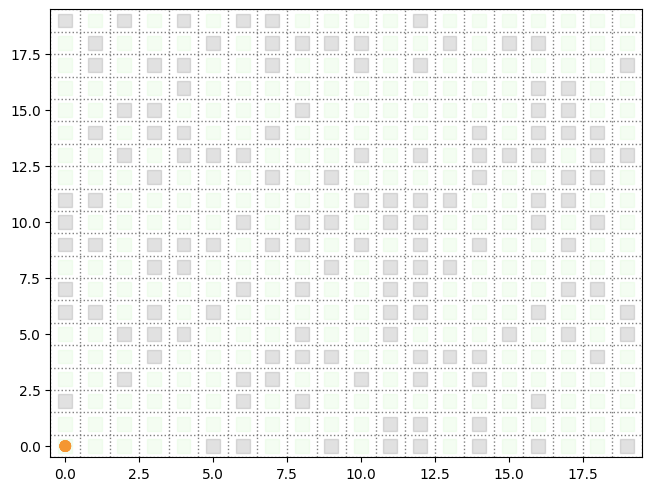

In [9]:
# === Cleaning Model con celdas coloreadas (Mesa >= 3.1) ===
import math
from typing import Tuple, Set

from mesa import Model
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle


# -----------------------------
# Utilidades robustas
# -----------------------------
def get_cell_by_coords(space, x, y):
    """Obtiene la celda (x,y) de forma compatible con distintas builds."""
    ac = getattr(space, "all_cells", None)
    if ac is None:
        return None
    # Camino 1: API con .select(...)
    if hasattr(ac, "select"):
        sel = ac.select(lambda c: c.coordinate == (x, y), at_most=1)
        cells = getattr(sel, "cells", None)
        if cells:
            return cells[0]
    # Camino 2: iterar (por si no hay .select)
    cells_iter = getattr(ac, "cells", ac)
    for c in cells_iter:
        if getattr(c, "coordinate", None) == (x, y):
            return c
    return None


# -----------------------------
# Agentes
# -----------------------------
class DirtCell(CellAgent):
    """Agente estático por celda; se pinta gris si sucia, verde si limpia."""
    def __init__(self, model: Model, cell, dirty: bool):
        super().__init__(model)
        self.cell = cell
        self.dirty = dirty

    def set_clean(self):
        self.dirty = False

    def step(self):
        pass  # no se mueve


class CleanAgent(CellAgent):
    def __init__(self, model: Model, cell):
        super().__init__(model)
        self.cell = cell
        self.moves = 0

    def _rand_moore_neighbor_cell(self):
        neighbors = list(self.cell.neighborhood.cells)
        return self.model.random.choice(neighbors) if neighbors else None

    def _clean_here(self):
        """Limpia cualquier DirtCell sucia en la celda actual (compat list/select)."""
        coord = self.cell.coordinate
        container = self.cell.agents
        if hasattr(container, "select"):
            dirt_list = container.select(
                lambda a: isinstance(a, DirtCell) and getattr(a, "dirty", False)
            ).agents
        else:
            dirt_list = [
                a for a in container
                if isinstance(a, DirtCell) and getattr(a, "dirty", False)
            ]
        for d in dirt_list:
            d.set_clean()
        if dirt_list:
            self.model.dirty_cells.discard(coord)

    def step(self):
        # Limpia donde está
        self._clean_here()
        # Muévete al azar (Moore)
        new_cell = self._rand_moore_neighbor_cell()
        if new_cell:
            self.cell = new_cell
            self.moves += 1
            self.model.total_moves += 1
            # Limpia al llegar
            self._clean_here()


# -----------------------------
# Modelo
# -----------------------------
class CleaningModel(Model):
    def __init__(
        self,
        width: int = 20,
        height: int = 20,
        num_agents: int = 5,
        dirty_pct: float = 0.35,
        max_steps: int = 10_000,
        seed: int | None = 42,
        torus: bool = False,
    ):
        super().__init__(seed=seed)
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.max_steps = max_steps
        self.step_count = 0
        self.total_moves = 0
        self.time_to_all_clean: int | None = None

        self.grid = OrthogonalMooreGrid(
            (self.width, self.height),
            capacity=math.inf,
            torus=torus,
            random=self.random,
        )

        # --- Celdas sucias iniciales ---
        all_coords = [(x, y) for x in range(self.width) for y in range(self.height)]
        self.random.shuffle(all_coords)
        k = int(round(max(0.0, min(1.0, dirty_pct)) * len(all_coords)))
        self.dirty_cells: Set[Tuple[int, int]] = set(all_coords[:k])

        # --- Crear un DirtCell para TODAS las celdas (pinta el tablero) ---
        for x in range(self.width):
            for y in range(self.height):
                c = get_cell_by_coords(self.grid, x, y)
                if c:
                    DirtCell(self, c, dirty=((x, y) in self.dirty_cells))

        # --- Crear limpiadores en (0,0) ---
        start_cell = get_cell_by_coords(self.grid, 0, 0)
        if start_cell is None:
            raise RuntimeError("No pude localizar la celda (0,0).")
        CleanAgent.create_agents(self, self.num_agents, [start_cell] * self.num_agents)

    def step(self):
        if self.step_count >= self.max_steps:
            return
        self.agents.shuffle_do("step")
        self.step_count += 1
        if not self.dirty_cells and self.time_to_all_clean is None:
            self.time_to_all_clean = self.step_count


# -----------------------------
# Portrayal (colores / tamaños)
# -----------------------------
def agent_portrayal(agent):
    if isinstance(agent, DirtCell):
        color = "#6b6b6b" if agent.dirty else "#c9f7c0"  # gris sucio, verde limpio
        return AgentPortrayalStyle(
            size=100, color=color, marker="s", alpha=0.20
        )
    if isinstance(agent, CleanAgent):
        return AgentPortrayalStyle(
            size=55, color="tab:orange", marker="o", alpha=1.0
        )
    return AgentPortrayalStyle(size=50, color="tab:blue")


# -----------------------------
# Sliders / parámetros UI
# -----------------------------
model_params = {
    "num_agents": {"type": "SliderInt", "value": 5, "label": "Agents", "min": 1, "max": 100, "step": 1},
    "dirty_pct": {"type": "SliderFloat", "value": 0.35, "label": "Dirty %", "min": 0.0, "max": 1.0, "step": 0.01},
    "width": {"type": "SliderInt", "value": 20, "label": "Width", "min": 5, "max": 50, "step": 1},
    "height": {"type": "SliderInt", "value": 20, "label": "Height", "min": 5, "max": 50, "step": 1},
    "torus": {"type": "Checkbox", "value": False, "label": "Torus (wrap)"},
    "max_steps": {"type": "SliderInt", "value": 1000, "label": "Max steps", "min": 10, "max": 20000, "step": 10},
    "seed": {"type": "SliderInt", "value": 42, "label": "Seed", "min": 0, "max": 10_000, "step": 1},
}


# -----------------------------
# Instancia + Visualizador
# -----------------------------
model = CleaningModel(
    width=model_params["width"]["value"],
    height=model_params["height"]["value"],
    num_agents=model_params["num_agents"]["value"],
    dirty_pct=model_params["dirty_pct"]["value"],
    max_steps=model_params["max_steps"]["value"],
    seed=model_params["seed"]["value"],
    torus=model_params["torus"]["value"],
)

renderer = SpaceRenderer(model=model, backend="matplotlib").render(
    agent_portrayal=agent_portrayal
)

page = SolaraViz(
    model,
    renderer,
    model_params=model_params,
    components=[],   # puedes añadir gráficos extra aquí
    name="Cleaning Model (Colored Cells)",
)

# En Jupyter, evalúa esta celda para ver los botones Start/Step/Reset:
page


In [ ]:
# -----------------------------
# Resultados al finalizar
# -----------------------------

# Experiment config
agent_counts = [1, 3, 5, 10, 15]      
num_runs = 5                        # number of repetitions for averaging

# store all results
records = []

for agents in agent_counts:
    for run in range(num_runs):
        result = compute_real_time(
            CleaningModel,
            width=20,
            height=20,
            num_agents=agents,
            dirty_pct=0.35,
            max_steps=1000,
            seed=42 + run,   # vary seed slightly for randomness
            torus=False,
        )
        result["num_agents"] = agents
        result["run"] = run + 1
        records.append(result)

# Print results
df = pd.DataFrame(records)

# aggregate averages and std
summary = (
    df.groupby("num_agents")
    .agg(
        avg_time=("steps_to_clean", "mean"),
        std_time=("steps_to_clean", "std"),
        avg_clean=("pct_clean_end", "mean"),
        avg_moves=("elapsed_seconds", "mean"), 
    )
    .reset_index()
)

print("Experimental Results Summary:")
print(summary.round(2))

Elapsed real time: 0.094 s
Steps until full clean: 737
Final cleanliness: 100.00%
